In [37]:
from IPython.display import clear_output

In [38]:
import time
import importlib
import numpy as np
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from scipy.linalg import norm, pinv, toeplitz
from scipy import fft
from tqdm import tqdm, trange

In [39]:
from numpy import pi, fft
import torch
from torch.nn.functional import relu, mse_loss, conv1d
from torch.nn import Module, Parameter, ReLU

device = torch.device('cuda')
print(device)

cuda


In [230]:
class ComplexLISTA(Module):
    
    def __init__(self, M, N, maxit):
        super(ComplexLISTA, self).__init__()
    
        # Real and imaginary Wg and We matricies 
        self.Wre = torch.nn.Parameter(torch.zeros([maxit+1, N, M]), requires_grad=True)
        self.Wrg = torch.nn.Parameter(torch.zeros([maxit+1, N, N]), requires_grad=True)
        self.Wie = torch.nn.Parameter(torch.zeros([maxit+1, N, M]), requires_grad=True)
        self.Wig = torch.nn.Parameter(torch.zeros([maxit+1, N, N]), requires_grad=True)
        
        # alpha and lambda hyper-parameters to LASSO/ISTA
        self.theta = torch.nn.Parameter(torch.ones(maxit+1), requires_grad=True)
        
        # Save the passed values
        self.M = M
        self.N = N
        self.maxit = maxit
        self.relu = ReLU()

        return
    
    def forward(self, yr, yi, epsilon=1e-10):
        
        Wret = torch.transpose(self.Wre[0], 0, 1)
        Wiet = torch.transpose(self.Wie[0], 0, 1)
        Wrgt = torch.transpose(self.Wrg[0], 0, 1)
        Wigt = torch.transpose(self.Wig[0], 0, 1)
                
        # Apply We branch to y to 0-th iteration
        zr = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
        zi = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
        
        # Apply soft-thresholding according to Eldar's paper.
        xabs = torch.sqrt(torch.square(zr) + torch.square(zi) + epsilon)
        xr = torch.divide(zr, xabs + epsilon) * self.relu(xabs - self.theta[0])
        xi = torch.divide(zi, xabs + epsilon) * self.relu(xabs - self.theta[0])
        
        for t in range(1, self.maxit+1):
            
            Wret = torch.transpose(self.Wre[0], 0, 1)
            Wiet = torch.transpose(self.Wie[0], 0, 1)
            Wrgt = torch.transpose(self.Wrg[0], 0, 1)
            Wigt = torch.transpose(self.Wig[0], 0, 1)
        
            # Apply We branch to y to t-th iteration
            ar = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
            ai = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
            
            # Apply Wg branch to x^(t) for t-th iteration
            br = torch.matmul(xr, Wrgt) - torch.matmul(xi, Wigt)
            bi = torch.matmul(xi, Wrgt) + torch.matmul(xr, Wigt)
            
            # Add the two branches                                                                           
            zr = ar + br
            zi = ai + bi
            
            # Apply soft-thresholding
            xabs = torch.sqrt(torch.square(zr) + torch.square(zi) + epsilon)
            xr = torch.divide(zr, xabs + epsilon) * self.relu(xabs - self.theta[t])
            xi = torch.divide(zi, xabs + epsilon) * self.relu(xabs - self.theta[t])
      
        return xr, xi

In [195]:
class ComplexLISTA_Toeplitz(Module):
    
    def __init__(self, M, N, maxit):
        super(ComplexLISTA_Toeplitz, self).__init__()
    
        # Real and imaginary Wg and We matricies 
        self.Wre = Parameter(torch.zeros([maxit+1, N, M]), requires_grad=True)
        self.Wie = Parameter(torch.zeros([maxit+1, N, M]), requires_grad=True)
        self.hrg = Parameter(torch.zeros([maxit+1, 1, 1, N]), requires_grad=True) # dimension such that it works with conv1d
        self.hig = Parameter(torch.zeros([maxit+1, 1, 1, N]), requires_grad=True)
        
        # alpha and lambda hyper-parameters to LASSO/ISTA
        self.theta = Parameter(torch.ones(maxit+1), requires_grad=True)
        
        # Save the passed values
        self.M = M
        self.N = N
        self.maxit = maxit
        self.relu = ReLU()

        return
    
    def forward(self, yr, yi, epsilon=1e-10):
        
        Wret = torch.transpose(self.Wre[0], 0, 1)
        Wiet = torch.transpose(self.Wie[0], 0, 1)
                
        # Apply We branch to y to 0-th iteration
        zr = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
        zi = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
        
        # Apply soft-thresholding according to Eldar's paper.
        xabs = torch.sqrt(torch.square(zr) + torch.square(zi) + epsilon)
        xr = torch.divide(zr, xabs + epsilon) * self.relu(xabs - self.theta[0])
        xi = torch.divide(zi, xabs + epsilon) * self.relu(xabs - self.theta[0])
        
        for t in range(1, self.maxit+1):

            Wret = torch.transpose(self.Wre[t], 0, 1)
            Wiet = torch.transpose(self.Wie[t], 0, 1)
            hrgt = self.hrg[t]
            higt = self.hig[t]
        
            # Apply We branch to y to t-th iteration
            ar = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
            ai = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
            
            # Apply hg conv1d branch to x^(t) for t-th iteration
            br = conv1d(xr.unsqueeze(1), hrgt, padding='same') - conv1d(xi.unsqueeze(1), higt, padding='same')
            bi = conv1d(xi.unsqueeze(1), hrgt, padding='same') + conv1d(xr.unsqueeze(1), higt, padding='same')
            
            # Add the two branches                                                                           
            zr = ar + br.squeeze(1)
            zi = ai + bi.squeeze(1)
            
            # Apply soft-thresholding
            xabs = torch.sqrt(torch.square(zr) + torch.square(zi) + epsilon)
            xr = torch.divide(zr, xabs + epsilon) * self.relu(xabs - self.theta[t])
            xi = torch.divide(zi, xabs + epsilon) * self.relu(xabs - self.theta[t])
      
        return xr, xi

In [250]:
class ComplexLISTA_Weights(Module):
    
    def __init__(self, M, N, maxit):
        super(ComplexLISTA_Weights, self).__init__()
    
        # Real and imaginary Wg and We matricies 
        self.Wre = Parameter(torch.zeros([maxit+1, N, M]), requires_grad=True)
        self.Wie = Parameter(torch.zeros([maxit+1, N, M]), requires_grad=True)
        self.Wg = Parameter(torch.zeros([maxit+1, M]), requires_grad=True) # dimension such that it works with conv1d
        
        # alpha and lambda hyper-parameters to LASSO/ISTA
        self.theta = Parameter(torch.ones(maxit+1), requires_grad=True)
        
        # Save the passed values
        self.M = M
        self.N = N
        self.maxit = maxit

        # Create useful relu layer
        self.relu = ReLU()

        # Assuming the measurement model
        self.complex_exp = lambda x : np.exp(2j*pi*x)
        self.fgrid = fft.fftfreq(N)
        self.ula = np.arange(M)
        self.arg = np.outer(self.ula, 2*pi*self.fgrid)

        # Predefine useful matricies
        self.C = torch.from_numpy(np.cos(self.arg)).to(torch.float32).unsqueeze(0).unsqueeze(0)
        self.S = torch.from_numpy(np.sin(self.arg)).to(torch.float32).unsqueeze(0).unsqueeze(0)
        self.C = Parameter(self.C, requires_grad=False)
        self.S = Parameter(self.S, requires_grad=False)

        return
    
    def forward(self, yr, yi, epsilon=1e-10):
        
        Wret = torch.transpose(self.Wre[0], 0, 1)
        Wiet = torch.transpose(self.Wie[0], 0, 1)
                
        # Apply We branch to y to 0-th iteration
        zr = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
        zi = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
        
        # Apply soft-thresholding according to Eldar's paper.
        xabs = torch.sqrt(torch.square(zr) + torch.square(zi) + epsilon)
        xr = torch.divide(zr, xabs + epsilon) * self.relu(xabs - self.theta[0])
        xi = torch.divide(zi, xabs + epsilon) * self.relu(xabs - self.theta[0])
        
        for t in range(1, self.maxit+1):

            Wret = torch.transpose(self.Wre[t], 0, 1)
            Wiet = torch.transpose(self.Wie[t], 0, 1)
        
            # Apply We branch to y to t-th iteration
            ar = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
            ai = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
            
            # Apply hg conv1d branch to x^(t) for t-th iteration
            hrgt = torch.matmul(self.Wg[t], self.C)
            higt = torch.matmul(self.Wg[t], self.S)

            br = conv1d(xr.unsqueeze(1), hrgt, padding='same') - conv1d(xi.unsqueeze(1), higt, padding='same')
            bi = conv1d(xi.unsqueeze(1), hrgt, padding='same') + conv1d(xr.unsqueeze(1), higt, padding='same')

            # Add the two branches                                                                           
            zr = ar + br.squeeze(1)
            zi = ai + bi.squeeze(1)
            
            # Apply soft-thresholding
            xabs = torch.sqrt(torch.square(zr) + torch.square(zi) + epsilon)
            xr = torch.divide(zr, xabs + epsilon) * self.relu(xabs - self.theta[t])
            xi = torch.divide(zi, xabs + epsilon) * self.relu(xabs - self.theta[t])
      
        return xr, xi

In [251]:
class sparse_dataset(Dataset):
    def __init__(self, N, K, Nexamples, sig=0.0, A=None):
        self.X = np.zeros((Nexamples, N, 1))
        for ii in range(Nexamples):
            self.X[ii,...] = self.generate_sparse_vector(N, K)
        #self.X *= np.random.randn(*self.X.shape)
        self.X = torch.from_numpy(self.X).reshape(Nexamples, N)
        self.Y = self.X @ A.T
    
    def __getitem__(self, i):
        return (self.X[i, ...], self.Y[i, ...])
    
    def __len__(self, ):
        return self.X.shape[0]
    
    def generate_sparse_vector(self, N, K):
        x = np.zeros((N,1))
        x[:K,...] = 1.
        np.random.shuffle(x)
        return x

In [252]:
# Create training data
maxit = 10
M = 64
N = 512
sig = 0.4
epochs = 10
batchSize = 20
testFreq = 1
trainingPoints = 10_000
testingPoints = 100
sparsityLevel = 5

# Create ULA and Nested Array Matricies
N1 = M // 2
N2 = M - N1

inner = np.arange(N1)
outer = np.arange(1, N2+1)*(N1 + 1) - 1

uniform = np.arange(M).reshape(-1,1)
nested = np.concatenate([inner, outer]).reshape(-1, 1)

fgrid = fft.fftfreq(N).reshape(-1, 1)

complex_exp = lambda x : np.exp(1j* 2*np.pi * x )
A_u = complex_exp(uniform @ fgrid.T)
A_n = complex_exp(nested @ fgrid.T)

In [253]:
''' Or load'''
dataset_training = torch.load("training_data.pt")
dataset_testing = torch.load("testing_data.pt")
dataloader_training = DataLoader(dataset_training, 
                                 batch_size = batchSize, shuffle=True)
dataloader_testing = DataLoader(dataset_testing, 
                                 batch_size = testingPoints, shuffle=False)

In [254]:
# dataset_training = sparse_dataset(N, sparsityLevel, trainingPoints, A=A_u)
# dataloader_training = DataLoader(dataset_training, 
#                                  batch_size = batchSize, shuffle=True)
# dataset_testing = sparse_dataset(N, sparsityLevel, testingPoints, A=A_u)
# dataloader_testing = DataLoader(dataset_testing, 
#                                  batch_size = testingPoints, shuffle=False)
# torch.save(dataset_training, "training_data.pt")
# torch.save(dataset_testing, "testing_data.pt")

In [255]:
batches = int(trainingPoints/batchSize)
#print(trainingPoints/batchSize)
training_losslist = np.zeros(epochs * batches)
testing_losslist = np.zeros(epochs * batches)

model = ComplexLISTA_Weights(M, N, maxit)
model.to(device)
# for name, weights in model.named_parameters():
#     print(name, weights)
#print(model.state_dict())
print(model.complex_exp)

<function ComplexLISTA_Weights.__init__.<locals>.<lambda> at 0x7faef94b4e60>


In [256]:
# Initialize Wg matrix according to Eldar
X, Y = dataset_training[:100]
print(X.shape, Y.shape)
X = X.numpy().T
Y = Y.numpy().T
XHX = X.T.conj() @ X 
XHXinv = pinv(XHX)
Phi = Y @ XHXinv @ X.T.conj() # conjugates omitted since X will be real
PhiH = torch.from_numpy(Phi.conj().T)
L = np.max(np.abs(np.linalg.eigvals(Phi.conj().T @ Phi)))

#print(model.state_dict()['Wre'])
with torch.no_grad():
    for name, param in model.named_parameters():
        if 'Wre' in name:
            param.copy_(1/L * PhiH.real)
        if 'Wie' in name:
            param.copy_(1/L * PhiH.imag)
        if 'Wg' in name: # for weighted lista
            param.copy_(1/L * torch.ones(model.maxit+1, M))
        if 'theta' in name:
            param.copy_(0.01/L * torch.ones(model.maxit+1))

print(model.state_dict()['Wre'][0])
print(model.state_dict()['Wre'][-1])

torch.Size([100, 512]) torch.Size([100, 64])
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 4.2930e-03,  6.3253e-04,  2.1935e-03,  ...,  1.8961e-03,
         -9.6310e-04, -2.0643e-04],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-2.5667e-05, -9.5074e-05,  1.0472e-03,  ...,  2.3814e-03,
          2.1650e-04, -4.2677e-04]], device='cuda:0')
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 4.2930e-03,  6.3253e-04,  2.1935e-03,  ...,  1.8961e-03,
         -9.6310e-04, -2.0643e-04

In [257]:
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
obj = torch.nn.MSELoss()
t = trange(epochs)
#t = range(epochs)
for e in t:
    for i, data in enumerate(dataloader_training):

        idx = e * batches + i
        x, y = data
        
        # Split data to real and complex
        xr = x.to(torch.float32).to(device)
        xi = torch.zeros_like(xr).to(torch.float32).to(device)
        
        yr = y.real.to(torch.float32).to(device)
        yi = y.imag.to(torch.float32).to(device)
        
        # Send through model
        xpredr, xpredi = model(yr, yi)
        
        loss = obj(xpredr, xr) + obj(xpredi, xi)

        with torch.no_grad():
            training_losslist[idx] = loss

        loss.backward()    
        optim.step()
        optim.zero_grad()
        
        if testFreq and idx % testFreq == 0:
            for k, test_data in enumerate(dataloader_testing):
                
                x, y = test_data
                
                xr = x.to(torch.float32).to(device)
                xi = torch.zeros_like(xr).to(torch.float32).to(device)
                
                yr = y.real.to(torch.float32).to(device)
                yi = y.imag.to(torch.float32).to(device)
                
                xpredr, xpredi = model(yr, yi)
                xpredr = xpredr.detach().cpu()
                xpredi = xpredi.detach().cpu()

                testing_losslist[idx] += torch.mean((xpredr.cpu() - xr.cpu())**2) + torch.mean((xpredi.cpu() - xi.cpu())**2)

        t.set_description("Batch: {}/{}\t Training Loss: {}\t Validation Loss: {}".format(i, len(dataloader_training), training_losslist[idx], testing_losslist[idx]), refresh=True)

        #clear_output(wait=True)
        #print("Epoch: {}\t Batch: {}\t Training Loss: {}\t Validation Loss: {}".format(e, i, training_losslist[idx], testing_losslist[idx]))

        #print("Epoch: {}\t Batch: {}\t Training Loss: {}\t".format(e, i, training_losslist[idx]), end='\r')

Batch: 499/500	 Training Loss: 0.008036364801228046	 Validation Loss: 0.008237844333052635: 100%|██████████| 10/10 [06:11<00:00, 37.16s/it]


50.088260650634766


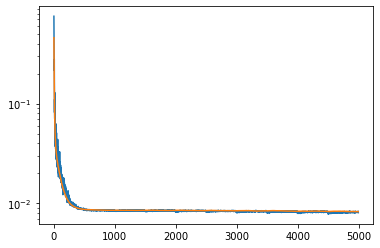

In [262]:
print(training_losslist[0])
plt.semilogy(training_losslist[10:])
plt.semilogy(testing_losslist[10:])
torch.save(model.state_dict(), "weights.pt")

In [ ]:
''' or load the weights '''
#model.load_state_dict(torch.load("model_weights.pt", map_location=device))

In [263]:
x_test, y_test = dataset_testing[2]

yr = y_test.real.to(torch.float32).to(device)
yi = y_test.imag.to(torch.float32).to(device)

yr = yr.unsqueeze(0)
yi = yi.unsqueeze(0)

xpredr, xpredi = model(yr, yi)
# xistar, xistai = model_ista(yr, yi)

x_test = x_test.numpy()
x_pred = np.zeros_like(x_test, dtype=complex)
x_pred.real = xpredr.detach().cpu().numpy()
x_pred.imag = xpredi.detach().cpu().numpy()

# x_ista = np.zeros_like(x_test, dtype=complex)
# x_ista.real = xistar.detach().numpy()
# x_ista.imag = xistai.detach().numpy()

S_test = np.abs(x_test)
S_pred = np.abs(x_pred)
# S_ista = np.abs(x_ista)

S_test /= S_test.max()
S_pred /= S_pred.max()
# S_ista /= S_ista.max()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys


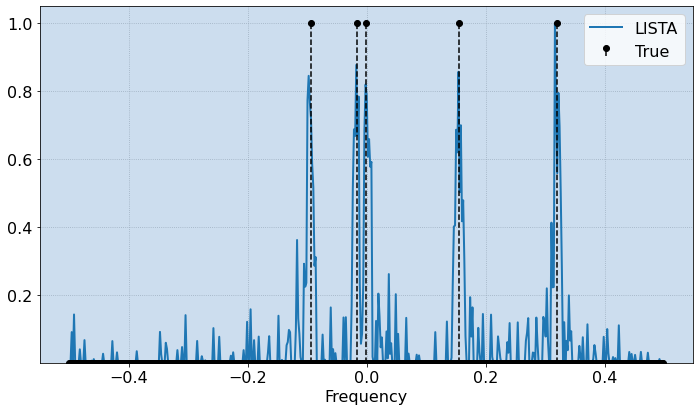

In [264]:
# Plot ULA
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(fft.fftshift(fft.fftfreq(N)), fft.fftshift(S_pred), linewidth=2, label='LISTA')
#ax.plot(fft.fftshift(fft.fftfreq(N)), fft.fftshift(S_ista), linewidth=2, label='ISTA')
ax.stem(fft.fftshift(fft.fftfreq(N)), fft.fftshift(S_test), 'k', markerfmt='ko', linefmt='k--', label='True',  basefmt=" ")
y1, y2 = ax.get_ylim()
#ax.vlines(fft.fftshift(fft.fftfreq(N)[np.nonzero(S_test)]), linestyle='--', ymin=0, ymax=y2, color='k', label='True')
ax.set_ylim(0.001, y2)
ax.set_xlabel('Frequency')
ax.set_title('')
ax.grid(color='#99AABB', linestyle=':')
ax.set_facecolor('#CCDDEE')

ax.legend()
plt.tight_layout()
plt.show()

In [131]:
abcd = torch.arange(N, dtype=torch.float32, requires_grad=True).unsqueeze(0).unsqueeze(0)
efgh = torch.arange(M, dtype=torch.float32, requires_grad=True).unsqueeze(0).unsqueeze(0)

ijkl = conv1d(abcd, efgh, padding='same')
print(abcd.shape)
print(efgh.shape)
print(ijkl.shape)

l = mse_loss(abcd, 2*ijkl)
l.backward()

print(l)

torch.Size([1, 1, 512])
torch.Size([1, 1, 64])
torch.Size([1, 1, 512])
tensor(1.3426e+12, grad_fn=<MseLossBackward>)
